# SARIMAX

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from itertools import product
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from scipy import stats

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
EPS = 1e-6

In [3]:
# Data minmax normalization
def norm(col, minimum, maximum, normalize):
    if normalize:
        return (col - minimum) / (maximum - minimum) + EPS
    else:
        return (col - EPS) * (maximum - minimum) + minimum

In [4]:
# Inv Box-Cox
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

## Avarage Temperature

<b>Read data</b>

In [5]:
train = pd.read_csv('data/tavg/train_1d.csv', index_col = ['date'], parse_dates = ['date'], dayfirst = True)
train = train.asfreq('d')
test = pd.read_csv('data/tavg/test_1d.csv', index_col = ['date'], parse_dates = ['date'], dayfirst = True)
test = test.asfreq('d')
data = pd.read_csv('data/tavg/full_1d.csv', index_col = ['date'], parse_dates = ['date'], dayfirst = True)
data = data.asfreq('d')

<b>Data normalization</b>

In [6]:
minimum = train.tavg.min()
maximum = train.tavg.max()

In [7]:
train['norm'] = norm(train.tavg, minimum, maximum, True)

In [8]:
train.head()

,tavg,norm
date,,
2011-01-01,-3.369167,0.411349
2011-01-02,-1.874167,0.439157
2011-01-03,-2.973333,0.418712
2011-01-04,-4.793750,0.384851
2011-01-05,-10.151250,0.285197


<b>Dispersion stabilization - Box-Cox</b>

In [9]:
train['box_cox'], lmbda = stats.boxcox(train.norm)
print("Optimal Box-Cox lambda: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train.box_cox)[1])

Optimal Box-Cox lambda: 1.178799
Dickey-Fuller test: p=0.059855


In [10]:
train.head()

,tavg,norm,box_cox
date,,,
2011-01-01,-3.369167,0.411349,-0.550612
2011-01-02,-1.874167,0.439157,-0.526747
2011-01-03,-2.973333,0.418712,-0.544321
2011-01-04,-4.793750,0.384851,-0.573086
2011-01-05,-10.151250,0.285197,-0.654997


<b>Seasonal differentiation</b>

In [11]:
train['differ'] = train.box_cox - train.box_cox.shift(12)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train.differ[12:])[1])

Dickey-Fuller test: p=0.000000


In [12]:
train.sample(5)

,tavg,norm,box_cox,differ
date,,,,
2014-09-19,9.144167,0.644106,-0.343242,-0.139084
2014-08-16,22.234583,0.887598,-0.111236,-0.038126
2013-07-02,22.731667,0.896844,-0.102176,0.078263
2011-03-25,-1.582083,0.444590,-0.522052,-0.035303
2014-11-23,-4.972500,0.381526,-0.575887,-0.167129


<b>Model selection</b>

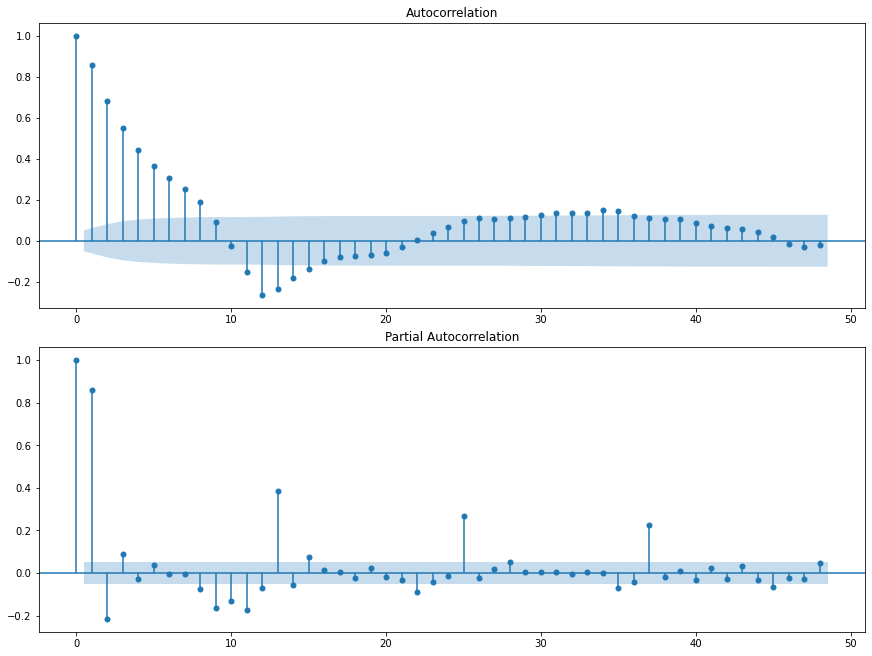

In [13]:
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(train.differ[12:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(train.differ[12:].values.squeeze(), lags=48, ax=ax)
plt.show();

In [14]:
# q = 8
# Q = 1
# p = 3
# P = 1
# d = 0
# D = 1

In [15]:
qs = range(0, 9)
Qs = range(0, 2)

ps = range(0, 4)
Ps = range(0, 2)

d = 0
D = 1

In [16]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [17]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is needed because on some parameter sets the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train.box_cox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print the parameters where the model can not be trained and go to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #save the best, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

  0%|          | 0/144 [00:00<?, ?it/s]

CPU times: user 44min 41s, sys: 8min 44s, total: 53min 26s
Wall time: 10min 21s


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))

       parameters          aic
53   (1, 4, 0, 1) -5193.620695
57   (1, 5, 0, 1) -5193.342351
61   (1, 6, 0, 1) -5191.919857
121  (3, 3, 0, 1) -5191.639657
49   (1, 3, 0, 1) -5190.792187
137  (3, 7, 0, 1) -5189.586310
141  (3, 8, 0, 1) -5189.570177
101  (2, 7, 0, 1) -5189.475295
55   (1, 4, 1, 1) -5187.954044
51   (1, 3, 1, 1) -5187.833948


In [19]:
# Best model
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              box_cox   No. Observations:                 1461
Model:             SARIMAX(1, 0, 4)x(0, 1, [1], 12)   Log Likelihood                2603.810
Date:                              Tue, 10 May 2022   AIC                          -5193.621
Time:                                      00:36:00   BIC                          -5156.670
Sample:                                  01-01-2011   HQIC                         -5179.831
                                       - 12-31-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9898      0.005    210.431      0.000       0.981       0.999
ma.L1          0.10

<b>Residuals analysis</b>

Student test: p=0.592442
Dickey-Fuller test: p=0.000000


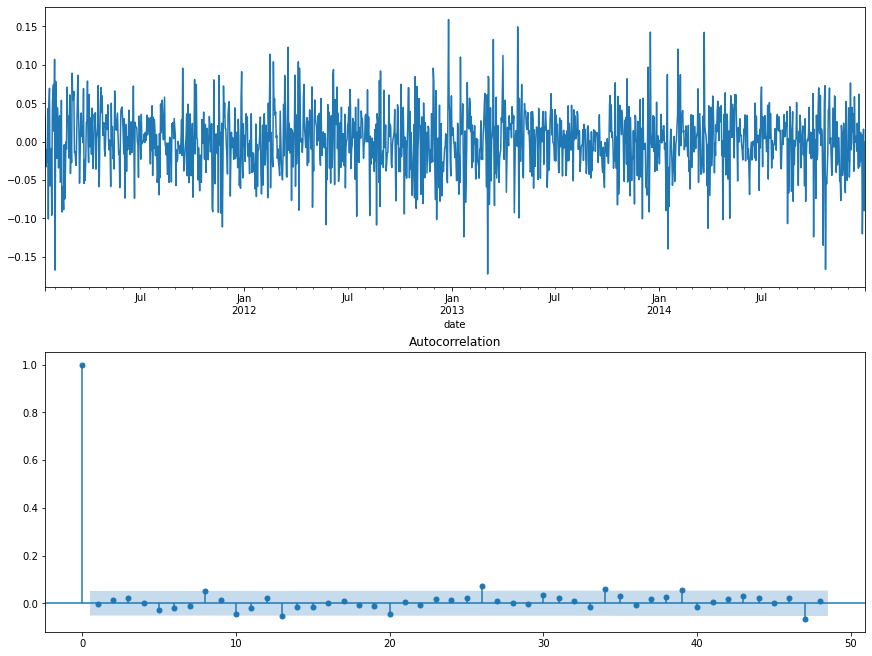

In [22]:
ax = plt.subplot(2, 1, 1)
best_model.resid[13:].plot()

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

<b>Validation on train data</b>

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


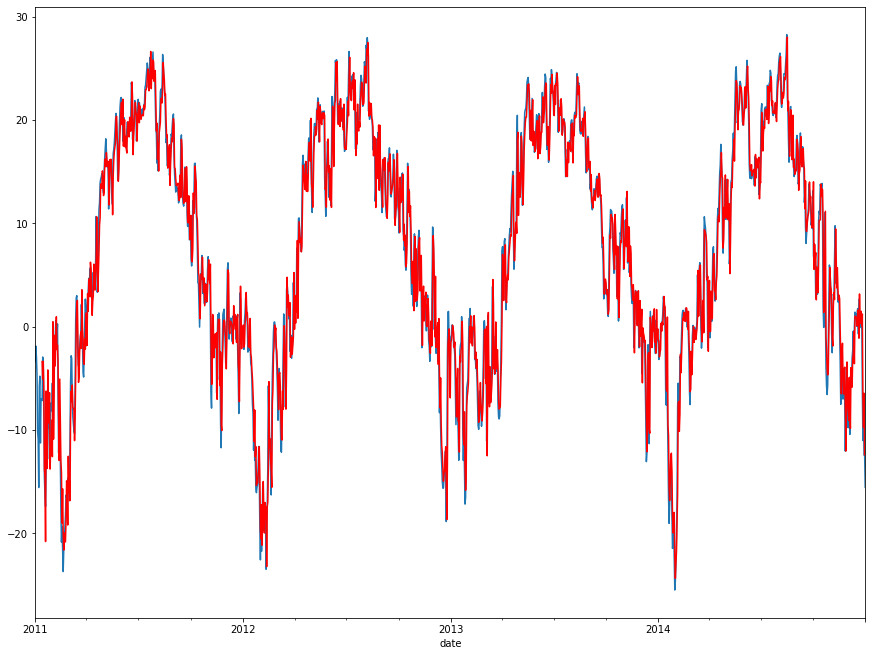

In [26]:
train['model'] = invboxcox(best_model.fittedvalues, lmbda)
train['denorm'] = norm(train.model, minimum, maximum, False)
train.tavg.plot();
train.denorm[12:].plot(color='r');

In [43]:
mean_squared_error(train.tavg[12:].values, np.nan_to_num(train.denorm[12:].values))

6.29205807033982

<b>Validation on test data</b>

In [47]:
test['model'] = best_model.predict(start=1461, end=1825)

In [49]:
test['invbox'] = invboxcox(test.model, lmbda)

In [51]:
test['denorm'] = norm(test.invbox, minimum, maximum, False)

In [55]:
test

,tavg,model,invbox,denorm
date,,,,
2015-01-01,-7.092500,-0.727836,0.190959,-15.217628
2015-01-02,-0.634583,-0.708920,0.216106,-13.865689
2015-01-03,1.475417,-0.697661,0.230825,-13.074349
2015-01-04,0.897917,-0.688123,0.243163,-12.411078
2015-01-05,-2.295833,-0.681617,0.251515,-11.962051
...,...,...,...,...
2015-12-27,-0.182083,-0.407487,0.573899,5.369711
2015-12-28,-6.087917,-0.412147,0.568748,5.092814
2015-12-29,-7.438750,-0.411457,0.569511,5.133832


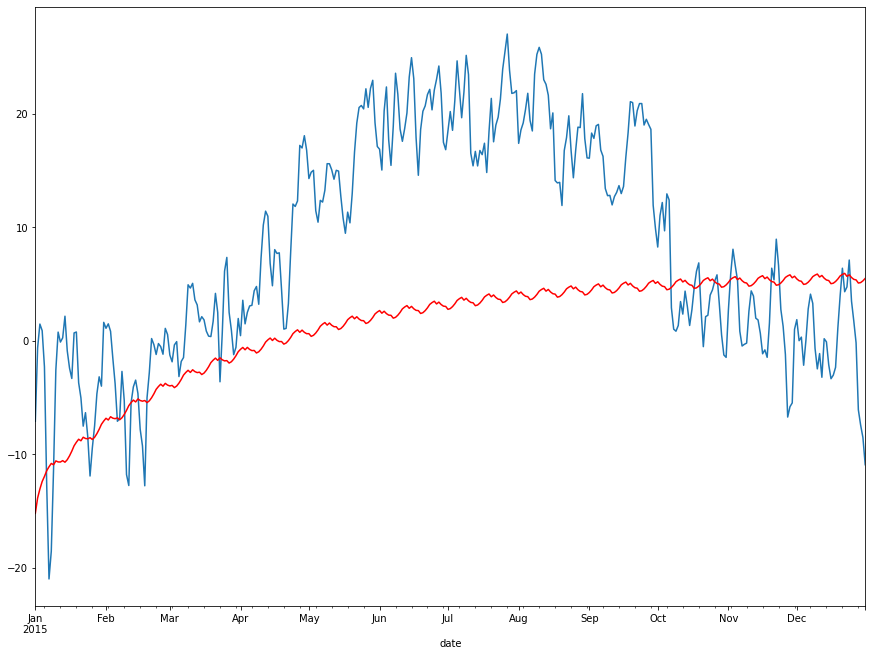

In [58]:
test.tavg.plot();
test.denorm.plot(color='r');